# Отчёт о проделанной работе

## Введение

**Задача:** Прогнозирование продаж товаров современными методами прогнозирования временных рядов

## Что сделано:

1. Реализован класс, позволяющий:
    - Предобработать данные в удобный вид
    - Собрать фичи
    - Обучить и получить предсказания от следующих моделей:
        - CatBoost
    - Оценить с помощью таблиц и графиков качество прогноза, в том числе:
        - Метрики ошибки прогнозирования
        - Качество остатков (стационарность, автокорреляции и др.)

2. Написан отчёт в формате Jupiter-ноутбука представляющий:
    - Общие сведения о проделанной работе
    - Описание методов модулей класса-решения
    - Демонстрация работы класса, включающая:
        - Препроцессинг
        - Обучение на 3 периода (7д, 30д, 90д) моделей, в том числе:
            - CatBoost
        - Визульная демонстрация предсказаний моделей

## Ответы на вопросы:

1. Какие методы предобработки данных вы использовали? Почему пробовали именно их?
Предобработкой было только замещение нулей и парсинг кат-фич (этого можно было не делать т.к. использовался catboost). В качестве дополнительных фич использовались данные ряда с лагом и скользящие средние для избежания утечек. (все данные брались после паддинга равного максимальному периоду прогнощирования в этом случае это 90)
2. Какие модели пробовали? Почему пробовали именно их?
В качестве реализации градиентного бустинга я выбрал CatBoost, т. к. он наиболее современный, быстрый и выполняет большую часть предобработки самостоятельно.
3. Как вы проверяете качество модели? На каких данных? Какие метрики используете? Чем обусловлен выбор именно этих метрик?
  - Дата сет был разбит на train и test с самого начала во избежание лаков, так же т.к. для прогноза на каждый из периодов используется одни и те же модели, в test отрезан сразу на максимальный из периодов.
  - Для оценки используется MAES, т. к. много нулевых данных и значения MAPE часто будут неопределяться, даже WAPE иногда Nan на первых товарах.
  - При обучении использовалось RMSE.
  - Качество модели оценивается как совокупность качества остатков (стационарность, гомоскедатичность, нормальность и тп) и метрик (mean, median, 95per и тп). Эти данные можно посмотреть в ./results/ или вывести из модели в конце отчёта.

## О решении

### Описание модулей 

#### solution.preprocessor

feature_engineering_lag - добавляет фичи на основе предыдущих значений ряда (лаги и скользящие средние)
feature_engineering_lag_store - feature_engineering_lag по всему магазину

#### solution.models

CatBoost - позволяет обучать модель и делать предикты.

## Демонстрация работы класса

### Импорты

In [1]:
import warnings
import pandas as pd
from solution.solution import Solution
warnings.filterwarnings("ignore")

### Глобальные переменные

In [2]:
CALENDAR = pd.read_csv('../source/shop_sales_dates.csv')
DATA = pd.read_csv('../source/shop_sales.csv')
PRICES = pd.read_csv('../source/shop_sales_prices.csv')
STORES = sorted(DATA['store_id'].unique())

PERIODS = {"week": 7, "month": 30, "quarter": 90}

ROW = 5
COLUMN = 3

FEATURE_ENGINEERING_LAGS_OPTIONS = {
    "lag_count": 7,
    "seasonal_lag": 7,
    "seasonal_lag_count": 10,
    "mean_sizes": [7, 30],
}

SOLUTION = Solution(ROW, COLUMN, PERIODS)


### Препроцессинг (собираем фичи)

In [3]:
STORE = STORES[0]
SOLUTION.load(STORE, DATA, CALENDAR, PRICES)
SOLUTION.feature_engineering_lags(FEATURE_ENGINEERING_LAGS_OPTIONS)
SOLUTION.group_by("abs_day")

In [4]:
SOLUTION.working[SOLUTION.items[0]].head()

item_id store_id  cnt  CASHBACK_STORE_1  CASHBACK_STORE_2  \
abs_day                                                                  
0        STORE_1_064  STORE_1    0                 0                 0   
1        STORE_1_064  STORE_1    1                 0                 0   
2        STORE_1_064  STORE_1    0                 0                 0   
3        STORE_1_064  STORE_1    0                 0                 1   
4        STORE_1_064  STORE_1    0                 1                 1   

         CASHBACK_STORE_3  sell_price  EVENT_Halloween  EVENT_Easter  \
abs_day                                                                
0                       0        2.54                0             0   
1                       0        2.54                0             0   
2                       0        2.54                0             0   
3                       1        2.54                0             0   
4                       0        2.54                0             0   

         EVENT_Christmas  ...  LAG_SEASONAL_3  LAG_SEASONAL_4  LAG_SEASONAL_5  \
abs_day                   ...                                                   
0                      0  ...             0.0             0.0             0.0   
1                      0  ...             0.0             0.0             0.0   
2                      0  ...             0.0             0.0             0.0   
3                      0  ...             0.0             0.0             0.0   
4                      0  ...             0.0             0.0             0.0   

         LAG_SEASONAL_6  LAG_SEASONAL_7  LAG_SEASONAL_8  LAG_SEASONAL_9  \
abs_day                                                                   
0                   0.0             0.0             0.0             0.0   
1                   0.0             0.0             0.0             0.0   
2                   0.0             0.0             0.0             0.0   
3                   0.0             0.0             0.0             0.0   
4                   0.0             0.0             0.0             0.0   

         LAG_SEASONAL_10  ROLLING_MEAN_7_LAG  ROLLING_MEAN_30_LAG  
abs_day                                                            
0                    0.0                 0.0                  0.0  
1                    0.0                 0.0                  0.0  
2                    0.0                 0.0                  0.0  
3                    0.0                 0.0                  0.0  
4                    0.0                 0.0                  0.0  

[5 rows x 67 columns]

In [5]:
print(SOLUTION.working[SOLUTION.items[0]].columns)

Index(['item_id', 'store_id', 'cnt', 'CASHBACK_STORE_1', 'CASHBACK_STORE_2',
       'CASHBACK_STORE_3', 'sell_price', 'EVENT_Halloween', 'EVENT_Easter',
       'EVENT_Christmas', 'EVENT_Father's day', 'EVENT_Cinco De Mayo',
       'EVENT_Mother's day', 'EVENT_LaborDay', 'EVENT_VeteransDay',
       'EVENT_Pesach End', 'EVENT_NBAFinalsEnd', 'EVENT_MartinLutherKingDay',
       'EVENT_LentWeek2', 'EVENT_Thanksgiving', 'EVENT_Ramadan starts',
       'EVENT_LentStart', 'EVENT_SuperBowl', 'EVENT_EidAlAdha',
       'EVENT_OrthodoxChristmas', 'EVENT_OrthodoxEaster', 'EVENT_MemorialDay',
       'EVENT_Purim End', 'EVENT_IndependenceDay', 'EVENT_Chanukah End',
       'EVENT_NewYear', 'EVENT_Eid al-Fitr', 'EVENT_PresidentsDay',
       'EVENT_NBAFinalsStart', 'EVENT_ColumbusDay', 'EVENT_ValentinesDay',
       'EVENT_StPatricksDay', 'EVENTTYPE_Cultural', 'EVENTTYPE_National',
       'EVENTTYPE_Sporting', 'EVENTTYPE_Religious', 'WEEKDAY_Saturday',
       'WEEKDAY_Wednesday', 'WEEKDAY_Friday', 'WEEKDA

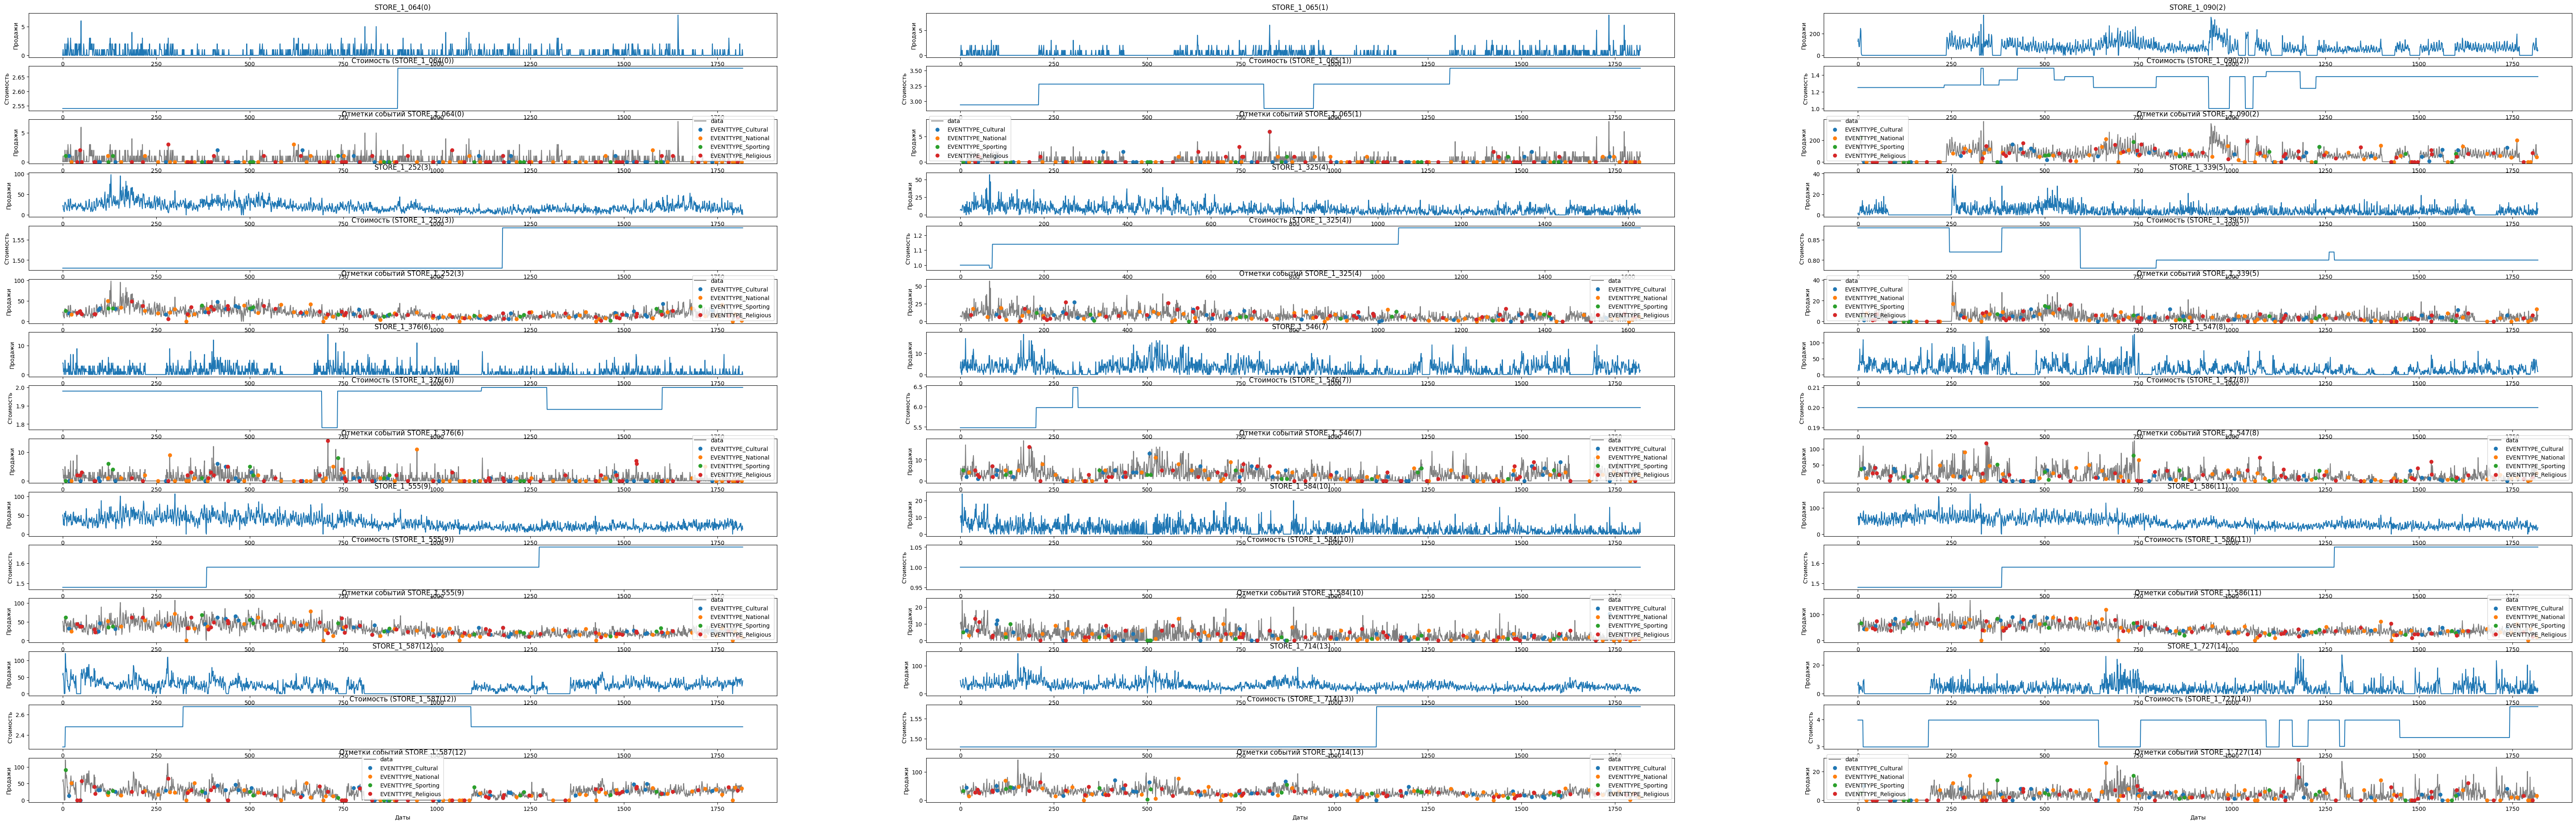

In [6]:
SOLUTION.visualize_dataset()

Разделим данные train/test для обучения на 3 сценария: 7 дней, 30 дней, 90 дней

In [7]:
SOLUTION.split_train_test()

### Анализ


#### Отчистка от нулей
По графикам рядов видно, что только для товаров под индексами 0, 1, 6, 7, 8 нули могут быть естественны, поэтому в остальных заменим нули предыдущим ненулевым значением. От всех нулей избавляться не будем, т. к. преобразование Йео-Джонсона этого не требует.

In [8]:
NATIVE_ZERO = {0, 1, 6, 7, 8}

SOLUTION.clean_zeros(NATIVE_ZERO)

STORE_1_090(2) zeroes: 451 -> 0
STORE_1_252(3) zeroes: 7 -> 0
STORE_1_325(4) zeroes: 125 -> 0
STORE_1_339(5) zeroes: 443 -> 0
STORE_1_555(9) zeroes: 5 -> 0
STORE_1_584(10) zeroes: 414 -> 0
STORE_1_586(11) zeroes: 5 -> 0
STORE_1_587(12) zeroes: 423 -> 0
STORE_1_714(13) zeroes: 6 -> 0
STORE_1_727(14) zeroes: 480 -> 0


### Предсказания

#### CatBoost

In [9]:
FIELDS = ['CASHBACK_STORE_1', 'CASHBACK_STORE_2', 'CASHBACK_STORE_3', 'sell_price', 'EVENT_IndependenceDay', 'EVENT_Eid al-Fitr', 'EVENT_OrthodoxChristmas', 'EVENT_NBAFinalsStart', 'EVENT_Easter', "EVENT_Mother's day", 'EVENT_Cinco De Mayo', 'EVENT_ColumbusDay', 'EVENT_MartinLutherKingDay', 'EVENT_Halloween', 'EVENT_Chanukah End', 'EVENT_Pesach End', 'EVENT_Purim End', "EVENT_Father's day", 'EVENT_EidAlAdha', 'EVENT_NBAFinalsEnd', 'EVENT_Thanksgiving', 'EVENT_StPatricksDay', 'EVENT_ValentinesDay', 'EVENT_VeteransDay', 'EVENT_MemorialDay', 'EVENT_Ramadan starts', 'EVENT_SuperBowl', 'EVENT_OrthodoxEaster', 'EVENT_LentWeek2', 'EVENT_Christmas', 'EVENT_PresidentsDay', 'EVENT_LentStart', 'EVENT_LaborDay', 'EVENT_NewYear', 'EVENTTYPE_National', 'EVENTTYPE_Sporting', 'EVENTTYPE_Cultural', 'EVENTTYPE_Religious', 'WEEKDAY_Monday', 'WEEKDAY_Wednesday', 'WEEKDAY_Thursday', 'WEEKDAY_Saturday', 'WEEKDAY_Friday', 'WEEKDAY_Tuesday', 'WEEKDAY_Sunday', 'LAG_1', 'LAG_2', 'LAG_3', 'LAG_4', 'LAG_5', 'LAG_6', 'LAG_7', 'LAG_SEASONAL_1', 'LAG_SEASONAL_2', 'LAG_SEASONAL_3', 'LAG_SEASONAL_4', 'LAG_SEASONAL_5', 'LAG_SEASONAL_6', 'LAG_SEASONAL_7', 'LAG_SEASONAL_8', 'LAG_SEASONAL_9', 'LAG_SEASONAL_10', 'ROLLING_MEAN_7_LAG', 'ROLLING_MEAN_30_LAG']

In [10]:
SOLUTION.fit(None, None, None, FIELDS)

fitting catboost models ...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 0.5682435	test: 0.8360319	best: 0.8360319 (0)	total: 165ms	remaining: 2m 44s
100:	learn: 0.4215521	test: 0.8488794	best: 0.8314205 (9)	total: 293ms	remaining: 2.61s
200:	learn: 0.3465087	test: 0.8582945	best: 0.8314205 (9)	total: 425ms	remaining: 1.69s
300:	learn: 0.2641039	test: 0.8663804	best: 0.8314205 (9)	total: 580ms	remaining: 1.35s
400:	learn: 0.2020203	test: 0.8728976	best: 0.8314205 (9)	total: 719ms	remaining: 1.07s
500:	learn: 0.1540097	test: 0.8748485	best: 0.8314205 (9)	total: 886ms	remaining: 882ms
600:	learn: 0.1211046	test: 0.8778327	best: 0.8314205 (9)	total: 1.06s	remaining: 703ms
700:	learn: 0.0950360	test: 0.8792632	best: 0.8314205 (9)	total: 1.19s	remaining: 509ms
800:	learn: 0.0756282	test: 0.8806679	best: 0.8314205 (9)	total: 1.32s	remaining: 328ms
900:	learn: 0.0623420	test: 0.8820021	best: 0.8314205 (9)	total: 1.45s	remaining: 160ms
999:	learn: 0.0498362	test: 0.8829678	best: 0.8314205 (9)	total: 1.61s	remaining: 0us

best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 0.6541120	test: 0.7410483	best: 0.7410483 (0)	total: 1.93ms	remaining: 1.92s
100:	learn: 0.5173019	test: 0.7413732	best: 0.7374831 (4)	total: 167ms	remaining: 1.49s
200:	learn: 0.4480763	test: 0.7529350	best: 0.7374831 (4)	total: 308ms	remaining: 1.22s
300:	learn: 0.3664800	test: 0.7614947	best: 0.7374831 (4)	total: 461ms	remaining: 1.07s
400:	learn: 0.3034169	test: 0.7722972	best: 0.7374831 (4)	total: 603ms	remaining: 901ms
500:	learn: 0.2561996	test: 0.7784555	best: 0.7374831 (4)	total: 737ms	remaining: 734ms
600:	learn: 0.2221201	test: 0.7829836	best: 0.7374831 (4)	total: 872ms	remaining: 579ms
700:	learn: 0.1960493	test: 0.7859890	best: 0.7374831 (4)	total: 1.04s	remaining: 442ms
800:	learn: 0.1818238	test: 0.7874509	best: 0.7374831 (4)	total: 1.19s	remaining: 295ms
900:	learn: 0.1720815	test: 0.7893616	best: 0.7374831 (4)	total: 1.33s	remaining: 147ms
999:	learn: 0.1638076	test: 0.7908437	best: 0.7374831 (4)	total: 1.49s	remaining: 0us

best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 26.0215370	test: 26.8694775	best: 26.8694775 (0)	total: 5.35ms	remaining: 5.34s
100:	learn: 13.1758651	test: 20.9727031	best: 20.9727031 (100)	total: 596ms	remaining: 5.3s
200:	learn: 8.6656800	test: 19.9531285	best: 19.9531285 (200)	total: 1.02s	remaining: 4.05s
300:	learn: 5.5178368	test: 19.7319216	best: 19.7203751 (293)	total: 1.43s	remaining: 3.33s
400:	learn: 3.6292763	test: 19.6723282	best: 19.5868179 (356)	total: 1.84s	remaining: 2.74s
500:	learn: 2.2523546	test: 19.6595674	best: 19.5868179 (356)	total: 2.22s	remaining: 2.21s
600:	learn: 1.5634030	test: 19.6292633	best: 19.5868179 (356)	total: 2.62s	remaining: 1.74s
700:	learn: 1.1043734	test: 19.6200902	best: 19.5868179 (356)	total: 3.05s	remaining: 1.3s
800:	learn: 0.7642148	test: 19.6188290	best: 19.5868179 (356)	total: 3.5s	remaining: 868ms
900:	learn: 0.5191433	test: 19.6200727	best: 19.5868179 (356)	total: 3.9s	remaining: 429ms
999:	learn: 0.3640559	test: 19.6176439	best: 19.5868179

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 6.9634148	test: 12.1464085	best: 12.1464085 (0)	total: 3.6ms	remaining: 3.59s
100:	learn: 4.2441370	test: 11.4129352	best: 11.4057754 (99)	total: 264ms	remaining: 2.35s
200:	learn: 2.8972192	test: 10.9331683	best: 10.9331683 (200)	total: 539ms	remaining: 2.14s
300:	learn: 1.8182938	test: 10.7235370	best: 10.7235370 (300)	total: 795ms	remaining: 1.84s
400:	learn: 1.1881505	test: 10.6642298	best: 10.6587965 (398)	total: 1.05s	remaining: 1.57s
500:	learn: 0.7772823	test: 10.6726005	best: 10.6587965 (398)	total: 1.3s	remaining: 1.29s
600:	learn: 0.4975378	test: 10.6751026	best: 10.6587965 (398)	total: 1.55s	remaining: 1.03s
700:	learn: 0.3371239	test: 10.6685814	best: 10.6587965 (398)	total: 1.79s	remaining: 763ms
800:	learn: 0.2217275	test: 10.6660735	best: 10.6587965 (398)	total: 2.08s	remaining: 518ms
900:	learn: 0.1433127	test: 10.6659113	best: 10.6587965 (398)	total: 2.36s	remaining: 259ms
999:	learn: 0.0910218	test: 10.6653120	best: 10.6587965 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 3.9489074	test: 4.1979704	best: 4.1979704 (0)	total: 2.65ms	remaining: 2.64s
100:	learn: 2.3972881	test: 4.3617127	best: 4.1979704 (0)	total: 211ms	remaining: 1.87s
200:	learn: 1.5556758	test: 4.4429893	best: 4.1979704 (0)	total: 397ms	remaining: 1.58s
300:	learn: 0.9767666	test: 4.4561531	best: 4.1979704 (0)	total: 588ms	remaining: 1.36s
400:	learn: 0.5809070	test: 4.4575634	best: 4.1979704 (0)	total: 783ms	remaining: 1.17s
500:	learn: 0.3567224	test: 4.4641884	best: 4.1979704 (0)	total: 983ms	remaining: 979ms
600:	learn: 0.2022347	test: 4.4615526	best: 4.1979704 (0)	total: 1.18s	remaining: 782ms
700:	learn: 0.1147415	test: 4.4621349	best: 4.1979704 (0)	total: 1.36s	remaining: 581ms
800:	learn: 0.0702716	test: 4.4623307	best: 4.1979704 (0)	total: 1.56s	remaining: 387ms
900:	learn: 0.0408143	test: 4.4632158	best: 4.1979704 (0)	total: 1.76s	remaining: 193ms
999:	learn: 0.0245844	test: 4.4632859	best: 4.1979704 (0)	total: 1.95s	remaining: 0us

best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 2.9966624	test: 2.9346954	best: 2.9346954 (0)	total: 2.39ms	remaining: 2.38s
100:	learn: 1.9511427	test: 2.9765092	best: 2.9317673 (5)	total: 245ms	remaining: 2.18s
200:	learn: 1.2321858	test: 3.0130209	best: 2.9317673 (5)	total: 490ms	remaining: 1.95s
300:	learn: 0.7700008	test: 3.0441344	best: 2.9317673 (5)	total: 682ms	remaining: 1.58s
400:	learn: 0.4678939	test: 3.0747627	best: 2.9317673 (5)	total: 863ms	remaining: 1.29s
500:	learn: 0.2835803	test: 3.0883669	best: 2.9317673 (5)	total: 1.08s	remaining: 1.07s
600:	learn: 0.1661278	test: 3.0982747	best: 2.9317673 (5)	total: 1.27s	remaining: 846ms
700:	learn: 0.0969377	test: 3.1037689	best: 2.9317673 (5)	total: 1.47s	remaining: 627ms
800:	learn: 0.0586207	test: 3.1065632	best: 2.9317673 (5)	total: 1.66s	remaining: 413ms
900:	learn: 0.0387047	test: 3.1085599	best: 2.9317673 (5)	total: 1.85s	remaining: 203ms
999:	learn: 0.0261668	test: 3.1093471	best: 2.9317673 (5)	total: 2.05s	remaining: 0us

best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 1.2064800	test: 0.9168626	best: 0.9168626 (0)	total: 2ms	remaining: 2s
100:	learn: 0.9694866	test: 0.9322301	best: 0.9097834 (31)	total: 176ms	remaining: 1.56s
200:	learn: 0.7457652	test: 0.9487906	best: 0.9097834 (31)	total: 328ms	remaining: 1.3s
300:	learn: 0.5467185	test: 0.9628551	best: 0.9097834 (31)	total: 484ms	remaining: 1.12s
400:	learn: 0.3861799	test: 0.9853062	best: 0.9097834 (31)	total: 623ms	remaining: 930ms
500:	learn: 0.2804985	test: 0.9911899	best: 0.9097834 (31)	total: 759ms	remaining: 756ms
600:	learn: 0.2228154	test: 0.9969940	best: 0.9097834 (31)	total: 900ms	remaining: 597ms
700:	learn: 0.1815272	test: 1.0006470	best: 0.9097834 (31)	total: 1.06s	remaining: 451ms
800:	learn: 0.1404855	test: 1.0021595	best: 0.9097834 (31)	total: 1.22s	remaining: 303ms
900:	learn: 0.1111566	test: 1.0031987	best: 0.9097834 (31)	total: 1.39s	remaining: 153ms
999:	learn: 0.0887670	test: 1.0043671	best: 0.9097834 (31)	total: 1.53s	remaining: 0us

b

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 2.6032474	test: 2.9429764	best: 2.9429764 (0)	total: 1.94ms	remaining: 1.94s
100:	learn: 1.4603987	test: 2.8883941	best: 2.8454030 (34)	total: 219ms	remaining: 1.95s
200:	learn: 0.9603326	test: 2.9326866	best: 2.8454030 (34)	total: 406ms	remaining: 1.61s
300:	learn: 0.6100008	test: 2.9516357	best: 2.8454030 (34)	total: 594ms	remaining: 1.38s
400:	learn: 0.4077011	test: 2.9495698	best: 2.8454030 (34)	total: 792ms	remaining: 1.18s
500:	learn: 0.2859448	test: 2.9482148	best: 2.8454030 (34)	total: 995ms	remaining: 991ms
600:	learn: 0.2024000	test: 2.9483266	best: 2.8454030 (34)	total: 1.19s	remaining: 791ms
700:	learn: 0.1441230	test: 2.9487890	best: 2.8454030 (34)	total: 1.39s	remaining: 593ms
800:	learn: 0.1028408	test: 2.9492186	best: 2.8454030 (34)	total: 1.57s	remaining: 391ms
900:	learn: 0.0742972	test: 2.9500919	best: 2.8454030 (34)	total: 1.76s	remaining: 193ms
999:	learn: 0.0520253	test: 2.9505613	best: 2.8454030 (34)	total: 1.96s	remaining:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 9.7411641	test: 14.7587089	best: 14.7587089 (0)	total: 4.38ms	remaining: 4.37s
100:	learn: 5.4954651	test: 14.3936251	best: 14.3936251 (100)	total: 387ms	remaining: 3.44s
200:	learn: 3.7849173	test: 14.3263698	best: 14.3192412 (186)	total: 717ms	remaining: 2.85s
300:	learn: 2.4677858	test: 14.2842446	best: 14.2599796 (276)	total: 1.05s	remaining: 2.44s
400:	learn: 1.5627439	test: 14.2700295	best: 14.2565966 (365)	total: 1.4s	remaining: 2.09s
500:	learn: 1.0341380	test: 14.2761035	best: 14.2565966 (365)	total: 1.74s	remaining: 1.73s
600:	learn: 0.7181549	test: 14.2782326	best: 14.2565966 (365)	total: 2.11s	remaining: 1.4s
700:	learn: 0.5019787	test: 14.2818711	best: 14.2565966 (365)	total: 2.45s	remaining: 1.04s
800:	learn: 0.3351749	test: 14.2864014	best: 14.2565966 (365)	total: 2.78s	remaining: 692ms
900:	learn: 0.2292129	test: 14.2863866	best: 14.2565966 (365)	total: 3.14s	remaining: 345ms
999:	learn: 0.1628119	test: 14.2858484	best: 14.2565966

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 7.0001072	test: 8.5161734	best: 8.5161734 (0)	total: 3.13ms	remaining: 3.13s
100:	learn: 3.9558009	test: 8.0684172	best: 8.0684172 (100)	total: 381ms	remaining: 3.39s
200:	learn: 2.5951469	test: 8.0610947	best: 8.0526478 (195)	total: 724ms	remaining: 2.88s
300:	learn: 1.5261097	test: 8.1058144	best: 8.0526478 (195)	total: 1.01s	remaining: 2.36s
400:	learn: 0.9115663	test: 8.1296445	best: 8.0526478 (195)	total: 1.29s	remaining: 1.93s
500:	learn: 0.5303098	test: 8.1519931	best: 8.0526478 (195)	total: 1.56s	remaining: 1.56s
600:	learn: 0.3063153	test: 8.1562142	best: 8.0526478 (195)	total: 1.83s	remaining: 1.22s
700:	learn: 0.1859266	test: 8.1572862	best: 8.0526478 (195)	total: 2.12s	remaining: 903ms
800:	learn: 0.1141762	test: 8.1587528	best: 8.0526478 (195)	total: 2.4s	remaining: 596ms
900:	learn: 0.0725138	test: 8.1596191	best: 8.0526478 (195)	total: 2.66s	remaining: 292ms
999:	learn: 0.0441213	test: 8.1601463	best: 8.0526478 (195)	total: 2.95s	r

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 2.0115150	test: 1.7148428	best: 1.7148428 (0)	total: 1.93ms	remaining: 1.93s
100:	learn: 1.1777354	test: 1.6711109	best: 1.6588941 (73)	total: 198ms	remaining: 1.76s
200:	learn: 0.7728633	test: 1.6768951	best: 1.6588941 (73)	total: 363ms	remaining: 1.44s
300:	learn: 0.4696726	test: 1.7091866	best: 1.6588941 (73)	total: 540ms	remaining: 1.25s
400:	learn: 0.2913674	test: 1.7214818	best: 1.6588941 (73)	total: 707ms	remaining: 1.06s
500:	learn: 0.1881734	test: 1.7340262	best: 1.6588941 (73)	total: 879ms	remaining: 875ms
600:	learn: 0.1196098	test: 1.7415430	best: 1.6588941 (73)	total: 1.07s	remaining: 708ms
700:	learn: 0.0752232	test: 1.7436560	best: 1.6588941 (73)	total: 1.24s	remaining: 528ms
800:	learn: 0.0509604	test: 1.7455194	best: 1.6588941 (73)	total: 1.41s	remaining: 350ms
900:	learn: 0.0360275	test: 1.7469812	best: 1.6588941 (73)	total: 1.57s	remaining: 172ms
999:	learn: 0.0249398	test: 1.7480167	best: 1.6588941 (73)	total: 1.74s	remaining:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 10.6902135	test: 10.8683239	best: 10.8683239 (0)	total: 3.53ms	remaining: 3.52s
100:	learn: 6.3893703	test: 9.8421101	best: 9.8393703 (99)	total: 362ms	remaining: 3.22s
200:	learn: 4.5430116	test: 9.6910926	best: 9.6824540 (196)	total: 719ms	remaining: 2.86s
300:	learn: 2.8335093	test: 9.6103748	best: 9.6096418 (299)	total: 1.08s	remaining: 2.51s
400:	learn: 1.7823368	test: 9.5895847	best: 9.5737637 (376)	total: 1.44s	remaining: 2.16s
500:	learn: 1.1323632	test: 9.5855510	best: 9.5737637 (376)	total: 1.77s	remaining: 1.77s
600:	learn: 0.7430980	test: 9.5749545	best: 9.5722692 (590)	total: 2.2s	remaining: 1.46s
700:	learn: 0.4702172	test: 9.5717880	best: 9.5694669 (679)	total: 2.56s	remaining: 1.09s
800:	learn: 0.2870715	test: 9.5706964	best: 9.5684450 (759)	total: 2.91s	remaining: 722ms
900:	learn: 0.1765599	test: 9.5709800	best: 9.5684450 (759)	total: 3.24s	remaining: 356ms
999:	learn: 0.1149362	test: 9.5702519	best: 9.5684450 (759)	total: 3.57s

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 9.8372251	test: 9.6897598	best: 9.6897598 (0)	total: 3.61ms	remaining: 3.61s
100:	learn: 4.8551023	test: 9.0297512	best: 9.0167018 (96)	total: 455ms	remaining: 4.05s
200:	learn: 3.0510997	test: 8.9242995	best: 8.9242995 (200)	total: 816ms	remaining: 3.24s
300:	learn: 2.1760030	test: 8.9973972	best: 8.9242995 (200)	total: 1.17s	remaining: 2.73s
400:	learn: 1.4465214	test: 9.0177694	best: 8.9242995 (200)	total: 1.54s	remaining: 2.3s
500:	learn: 0.9994506	test: 9.0496368	best: 8.9242995 (200)	total: 1.89s	remaining: 1.88s
600:	learn: 0.6820480	test: 9.0473264	best: 8.9242995 (200)	total: 2.23s	remaining: 1.48s
700:	learn: 0.4876836	test: 9.0535940	best: 8.9242995 (200)	total: 2.64s	remaining: 1.13s
800:	learn: 0.3467342	test: 9.0566315	best: 8.9242995 (200)	total: 3.04s	remaining: 755ms
900:	learn: 0.2516678	test: 9.0600988	best: 8.9242995 (200)	total: 3.39s	remaining: 373ms
999:	learn: 0.1724221	test: 9.0601946	best: 8.9242995 (200)	total: 3.73s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 8.5088388	test: 9.8618584	best: 9.8618584 (0)	total: 3.53ms	remaining: 3.52s
100:	learn: 5.3987981	test: 10.0709033	best: 9.8618584 (0)	total: 394ms	remaining: 3.51s
200:	learn: 3.3550268	test: 10.1113729	best: 9.8618584 (0)	total: 726ms	remaining: 2.89s
300:	learn: 2.1499540	test: 10.1838965	best: 9.8618584 (0)	total: 1.09s	remaining: 2.52s
400:	learn: 1.3864042	test: 10.2398898	best: 9.8618584 (0)	total: 1.43s	remaining: 2.13s
500:	learn: 0.9360860	test: 10.2536976	best: 9.8618584 (0)	total: 1.76s	remaining: 1.75s
600:	learn: 0.6429500	test: 10.2736971	best: 9.8618584 (0)	total: 2.11s	remaining: 1.4s
700:	learn: 0.4316134	test: 10.2747515	best: 9.8618584 (0)	total: 2.43s	remaining: 1.03s
800:	learn: 0.3000217	test: 10.2797235	best: 9.8618584 (0)	total: 2.73s	remaining: 679ms
900:	learn: 0.2020662	test: 10.2837835	best: 9.8618584 (0)	total: 3.08s	remaining: 339ms
999:	learn: 0.1366193	test: 10.2854605	best: 9.8618584 (0)	total: 3.42s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 3.9378935	test: 4.3713888	best: 4.3713888 (0)	total: 2.77ms	remaining: 2.76s
100:	learn: 2.3191079	test: 4.6586660	best: 4.3713888 (0)	total: 348ms	remaining: 3.1s
200:	learn: 1.5660726	test: 4.7440017	best: 4.3713888 (0)	total: 619ms	remaining: 2.46s
300:	learn: 1.0100605	test: 4.7644310	best: 4.3713888 (0)	total: 871ms	remaining: 2.02s
400:	learn: 0.6602850	test: 4.7950031	best: 4.3713888 (0)	total: 1.13s	remaining: 1.69s
500:	learn: 0.4451765	test: 4.8006259	best: 4.3713888 (0)	total: 1.36s	remaining: 1.35s
600:	learn: 0.3042588	test: 4.8063750	best: 4.3713888 (0)	total: 1.62s	remaining: 1.08s
700:	learn: 0.2051536	test: 4.8101281	best: 4.3713888 (0)	total: 1.86s	remaining: 794ms
800:	learn: 0.1414410	test: 4.8146605	best: 4.3713888 (0)	total: 2.13s	remaining: 530ms
900:	learn: 0.0985487	test: 4.8154144	best: 4.3713888 (0)	total: 2.41s	remaining: 265ms
999:	learn: 0.0693925	test: 4.8151094	best: 4.3713888 (0)	total: 2.64s	remaining: 0us

bestT

In [11]:
SOLUTION.predict()

predicting catboost models ...


### Скоринг

Результаты на week: 


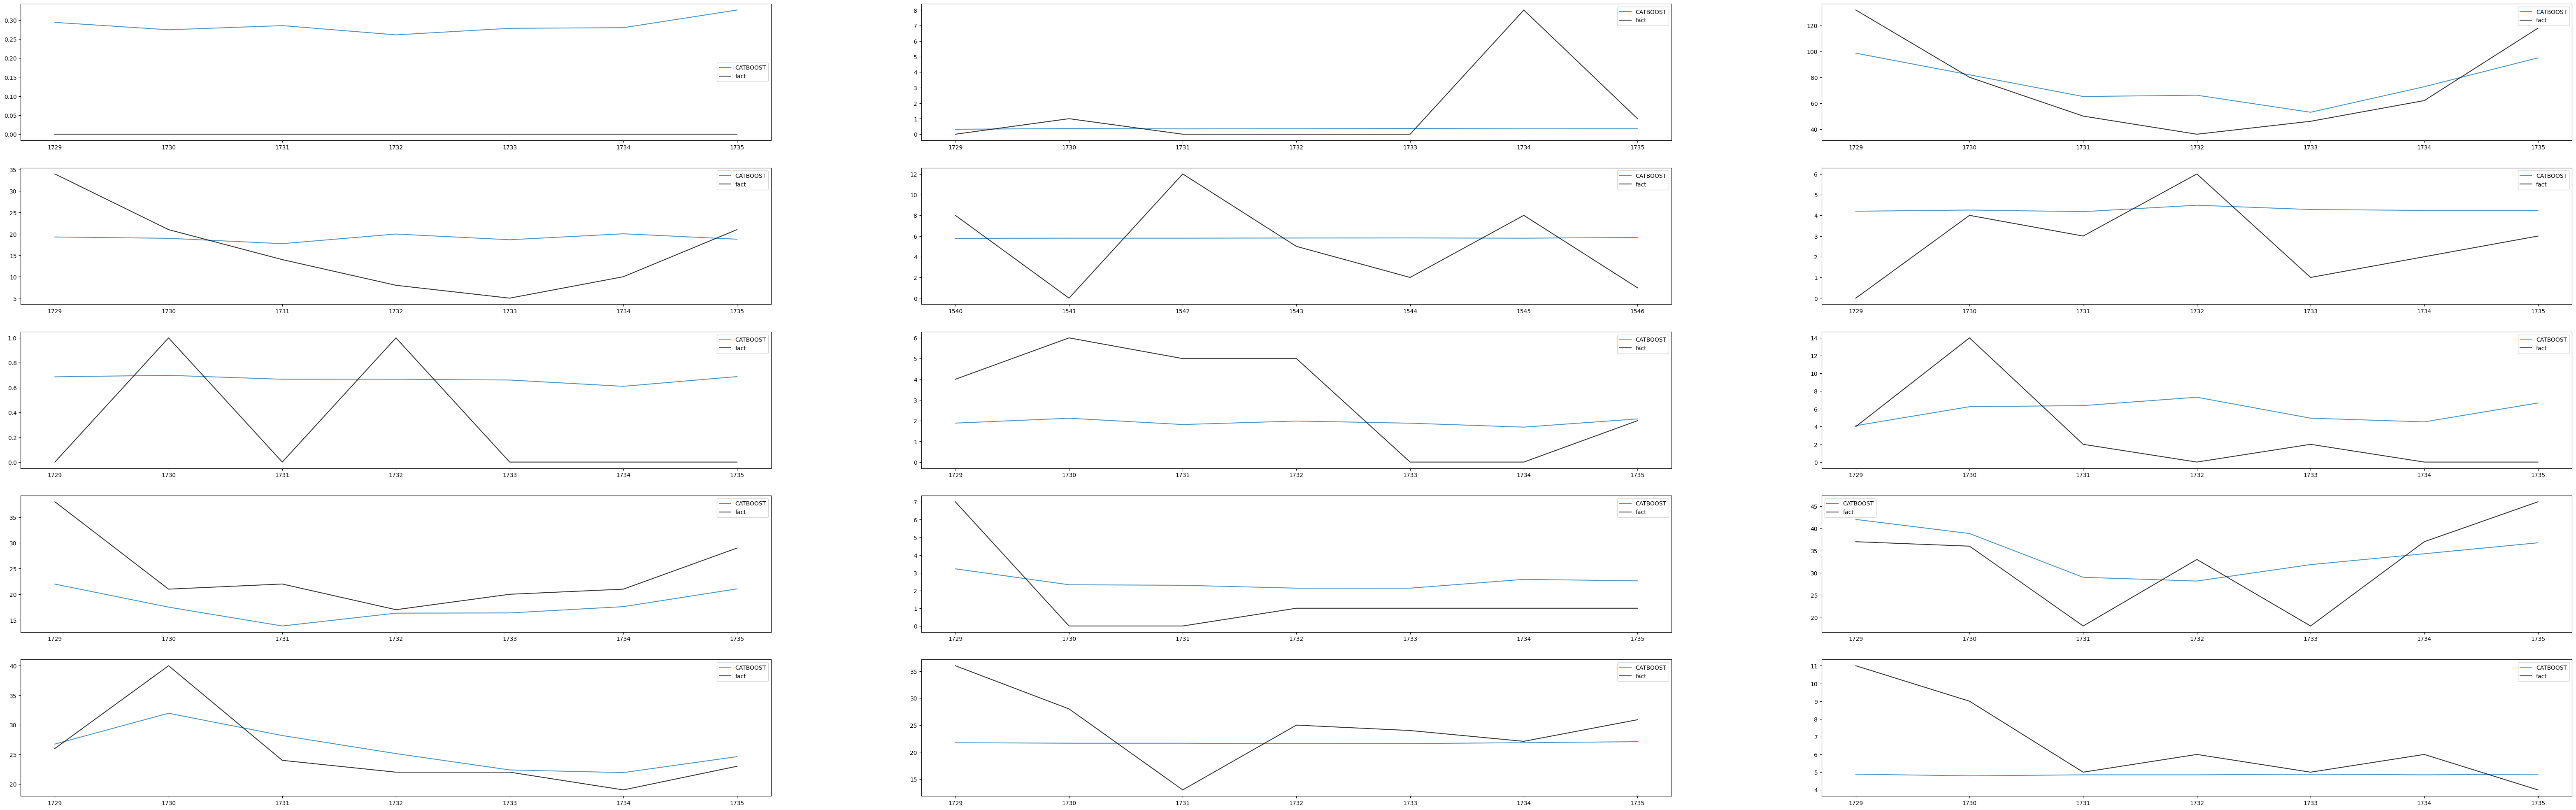

Результаты на month: 


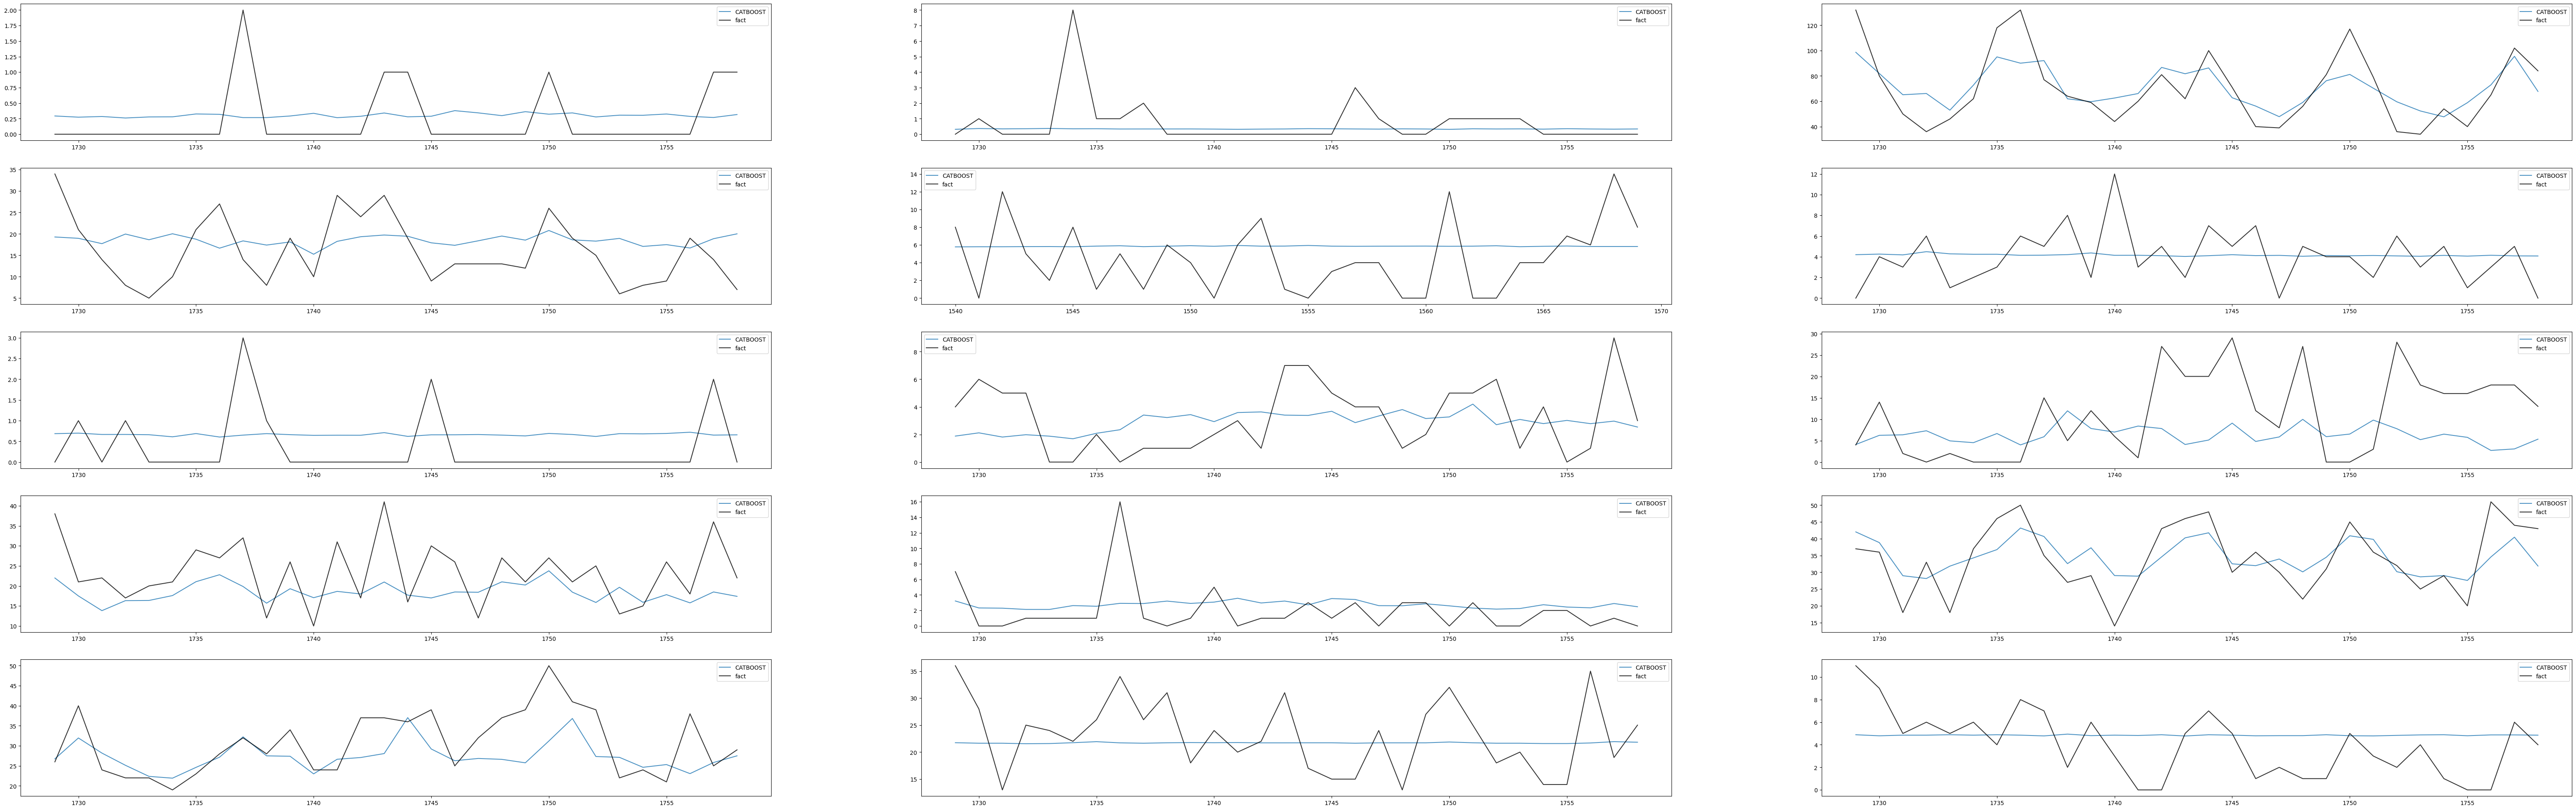

Результаты на quarter: 


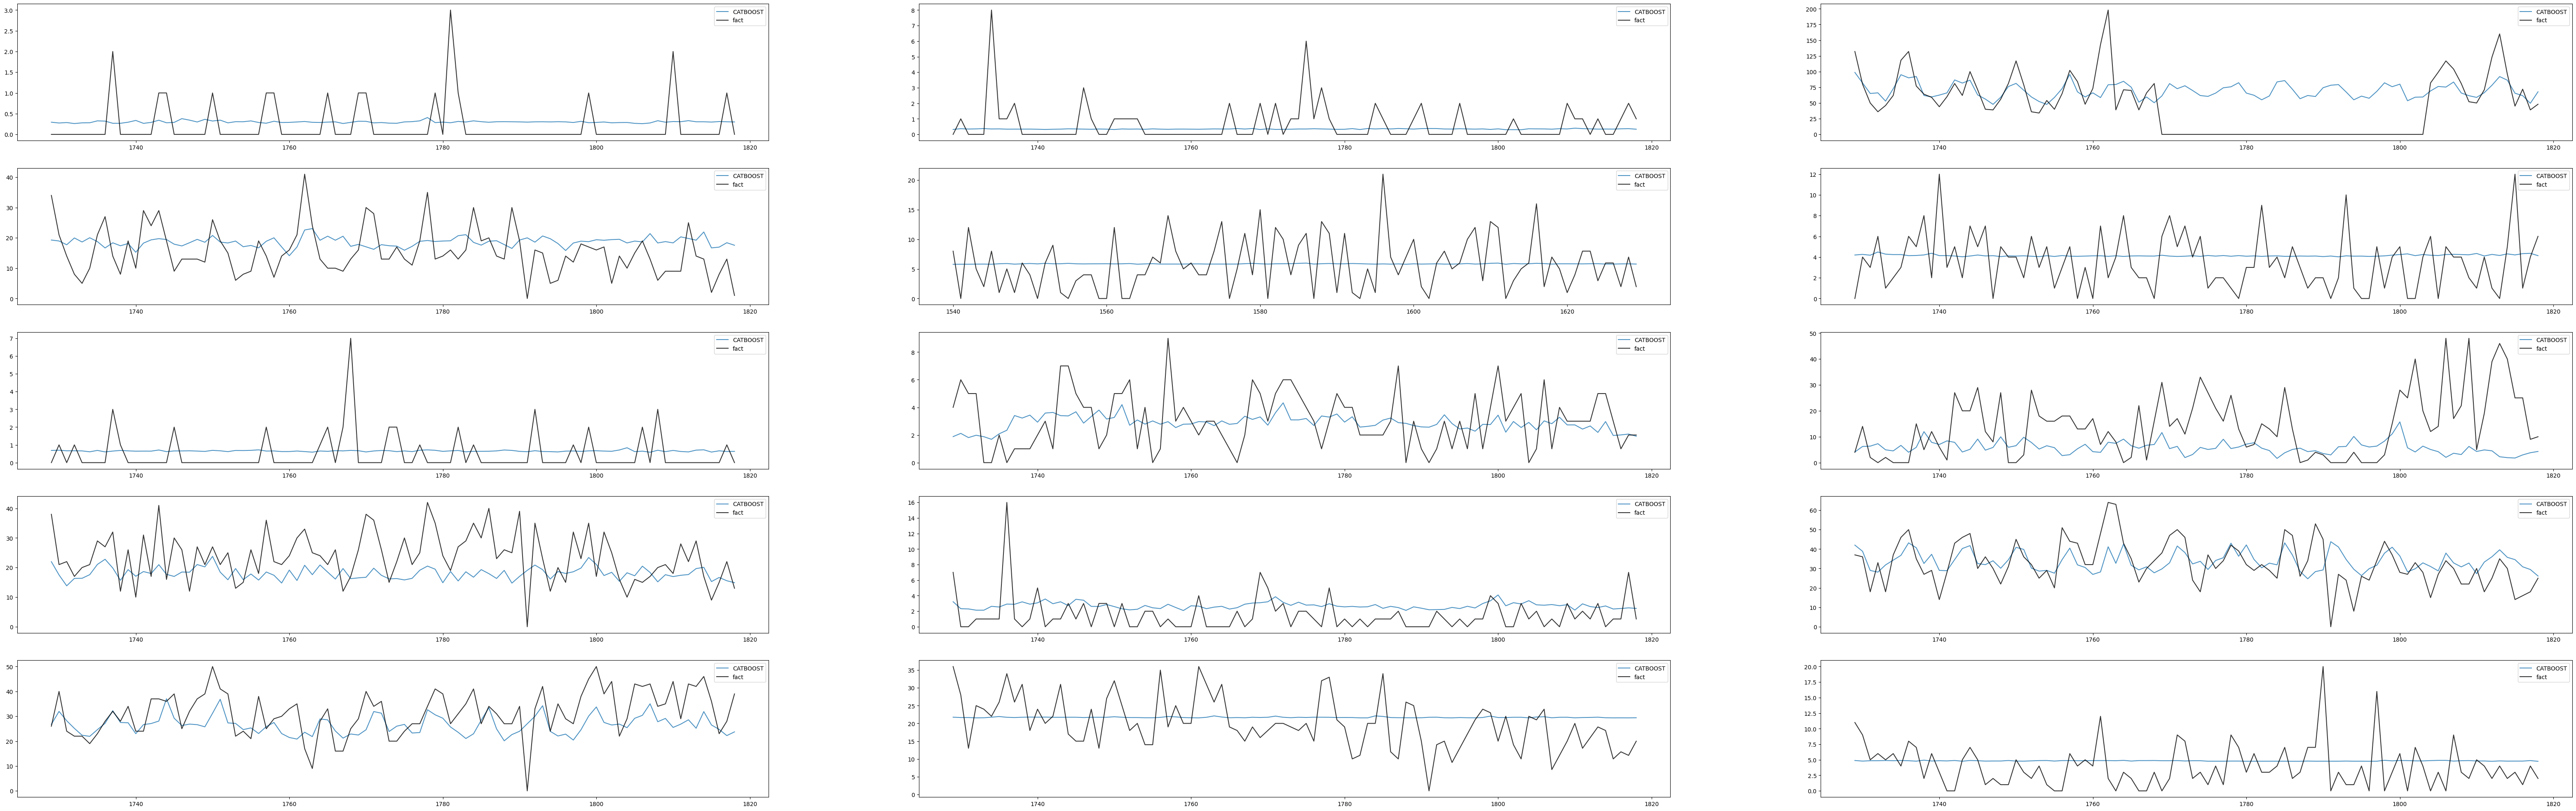

In [12]:
SOLUTION.scoring_predicts()

Выведем победителей:

In [13]:
SOLUTION.print_best()

Результаты по week:
STORE_1_064(0) best: CATBOOST (0.2799460278053939)
STORE_1_065(1) best: CATBOOST (0.3732531381603833)
STORE_1_090(2) best: CATBOOST (15.148537619633885)
STORE_1_252(3) best: CATBOOST (10.03249259413667)
STORE_1_325(4) best: CATBOOST (3.8161217440921424)
STORE_1_339(5) best: CATBOOST (1.5104638105365558)
STORE_1_376(6) best: CATBOOST (0.6605635855808839)
STORE_1_546(7) best: CATBOOST (2.117340245536621)
STORE_1_547(8) best: CATBOOST (4.530759435522235)
STORE_1_555(9) best: CATBOOST (3.627626376959384)
STORE_1_584(10) best: CATBOOST (1.6282516720767837)
STORE_1_586(11) best: CATBOOST (5.029699158529986)
STORE_1_587(12) best: CATBOOST (2.9306608605906774)
STORE_1_714(13) best: CATBOOST (4.064489761382443)
STORE_1_727(14) best: CATBOOST (1.149380944455726)
Результаты по month:
STORE_1_064(0) best: CATBOOST (0.3058429332123114)
STORE_1_065(1) best: CATBOOST (0.351208588062102)
STORE_1_090(2) best: CATBOOST (12.20335446580144)
STORE_1_252(3) best: CATBOOST (5.945479857339

Посмотреть полный скоринг по предметы и периоду:

In [14]:
SOLUTION.scoring_results[SOLUTION.items[1]]["week"]

mean    median    quan75    quan95       std  \
CATBOOST  1.47432  0.373253  0.639886  5.550789  2.727822   

                 no_stationary is_stationary no_autocorrelation  \
CATBOOST  0.15753728931861255❌          0.1✅               0.0✅   

           is_homoscedasticity         is_mean_zero             is_normality  
CATBOOST  0.36048415872847495✅  0.3690080589939132✅  0.00012822416437770003❌